In [5]:
# Import necessary libraries and methods
import os
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import optuna
from optuna.integration import OptunaSearchCV

In [2]:
# Load training scaled datasets
data_path = "../data/preprocessed/preprocessed_data_20250720_131842"

X_train = pd.read_csv(os.path.join(data_path, 'X_train_scaled.csv'))
y_train = pd.read_csv(os.path.join(data_path, 'y_train_scaled.csv'))

# Load test datasets
X_test = pd.read_csv(os.path.join(data_path, 'X_test_scaled.csv'))
y_test = pd.read_csv(os.path.join(data_path, 'y_test_scaled.csv'))

In [3]:
# Flatten y_train and y_test to be (n_samples, )
y_train_reshaped = np.ravel(y_train) 
y_test_reshaped = np.ravel(y_test)
print(y_train_reshaped.shape)
print(y_test_reshaped.shape)

(1688,)
(423,)


### I) Experiment with baseline model using Support Vector Classifier (SVC)

In [4]:
# Baseline pipeline using Support Vector Classifier (SVC) as model
pipe_svc = Pipeline([
    ('svc', SVC(random_state = 42))
])

# Define parameter grid search for SVC
param_grid_svc = {
    'svc__C': [1, 10, 50],
    'svc__kernel': ['rbf', 'poly'],
    'svc__gamma': ['scale', 'auto']
}

# GridSearchCV with 'accuracy' as the scoring metric
grid_svc = GridSearchCV(pipe_svc, param_grid_svc, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_svc.fit(X_train, y_train_reshaped)

# Print the best parameters and score
print(f"\nBest SVC parameters: {grid_svc.best_params_}")
print(f"Best cross-validated Accuracy: {grid_svc.best_score_:.4f}")

# Evaluate the best model on the test set
y_pred_svc = grid_svc.predict(X_test)
train_accuracy_svc = accuracy_score(y_train_reshaped, grid_svc.predict(X_train))
test_accuracy_svc = accuracy_score(y_test_reshaped, y_pred_svc)

print(f"SVC Train Accuracy: {train_accuracy_svc:.4f}")
print(f"SVC Test Accuracy: {test_accuracy_svc:.4f}")

print("\nSVC Test Set Classification Report:")
print(classification_report(y_test, y_pred_svc))

Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best SVC parameters: {'svc__C': 50, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
Best cross-validated Accuracy: 0.9485
SVC Train Accuracy: 0.9970
SVC Test Accuracy: 0.9551

SVC Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        54
           1       0.85      0.95      0.89        58
           2       0.96      1.00      0.98        70
           3       0.98      1.00      0.99        60
           4       1.00      0.98      0.99        65
           5       0.94      0.86      0.90        58
           6       1.00      0.91      0.95        58

    accuracy                           0.96       423
   macro avg       0.96      0.95      0.95       423
weighted avg       0.96      0.96      0.96       423



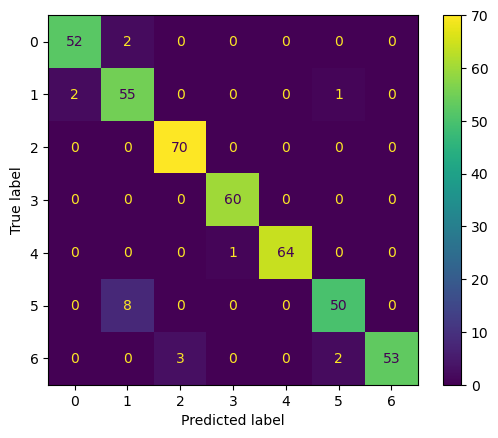

In [6]:
# Create SVC confusion matrix
cm_svc = confusion_matrix(y_test_reshaped, y_pred_svc)
ConfusionMatrixDisplay(confusion_matrix=cm_svc).plot();

### II) Compare GridSearch CV vs Optuna performance

In [7]:
# Use same svc pipeline and parameters but with optuna instead of GridSearchCV
pipe_svc = Pipeline([
    ('svc', SVC(random_state = 42))
])

# Define parameter grid search for SVC
param_grid_opt = {
    'svc__C': optuna.distributions.IntDistribution(1, 10, 50),
    'svc__kernel': optuna.distributions.CategoricalDistribution(['rbf', 'poly']),
    'svc__gamma': optuna.distributions.CategoricalDistribution(['scale', 'auto']),
}

# GridSearchCV with 'accuracy' as the scoring metric
opt_svc = OptunaSearchCV(pipe_svc, param_grid_opt, n_trials = 20,
                         cv = 5, scoring = 'accuracy', n_jobs = -1,
                         verbose = 1)

opt_svc.fit(X_train, y_train_reshaped)

# Print the best parameters and score
print(f"\nBest SVC Opt parameters: {opt_svc.best_params_}")
print(f"Best cross-validated Accuracy: {opt_svc.best_score_:.4f}")

# Evaluate the best model on the test set
y_pred_opt = opt_svc.predict(X_test)
train_acc_opt = accuracy_score(y_train_reshaped, opt_svc.predict(X_train))
test_acc_opt = accuracy_score(y_test_reshaped, y_pred_opt)

print(f"SVC Opt Train Accuracy: {train_acc_opt:.4f}")
print(f"SVC Opt Test Accuracy: {test_acc_opt:.4f}")

print("\nSVC Opt Test Set Classification Report:")
print(classification_report(y_test, y_pred_opt))

/var/folders/_c/rmwlj3rx6sl64n4g6ykhb47w0000gn/T/ipykernel_48626/2493019620.py:14: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  opt_svc = OptunaSearchCV(pipe_svc, param_grid_opt, n_trials = 20,
[I 2025-07-23 11:42:10,505] A new study created in memory with name: no-name-df41da66-7214-4b6b-8e77-c4696d7a7d4f
[I 2025-07-23 11:42:11,659] Trial 0 finished with value: 0.9360156620371184 and parameters: {'svc__C': 1, 'svc__kernel': 'poly', 'svc__gamma': 'auto'}. Best is trial 0 with value: 0.9360156620371184.
[I 2025-07-23 11:42:11,738] Trial 2 finished with value: 0.9407564131827998 and parameters: {'svc__C': 2, 'svc__kernel': 'poly', 'svc__gamma': 'auto'}. Best is trial 2 with value: 0.9407564131827998.
[I 2025-07-23 11:42:11,820] Trial 3 finished with value: 0.9407546573490422 and parameters: {'svc__C': 7, 'svc__kernel': 'poly', 'svc__gamma': 'auto'}. Best is trial 2 with value: 0.9407564131827998.
[I 2025-07-23 11:


Best SVC Opt parameters: {'svc__C': 4, 'svc__kernel': 'poly', 'svc__gamma': 'auto'}
Best cross-validated Accuracy: 0.9431
SVC Opt Train Accuracy: 0.9976
SVC Opt Test Accuracy: 0.9669

SVC Opt Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        54
           1       0.93      0.97      0.95        58
           2       0.96      0.97      0.96        70
           3       0.98      1.00      0.99        60
           4       1.00      0.98      0.99        65
           5       0.96      0.90      0.93        58
           6       0.95      0.95      0.95        58

    accuracy                           0.97       423
   macro avg       0.97      0.97      0.97       423
weighted avg       0.97      0.97      0.97       423



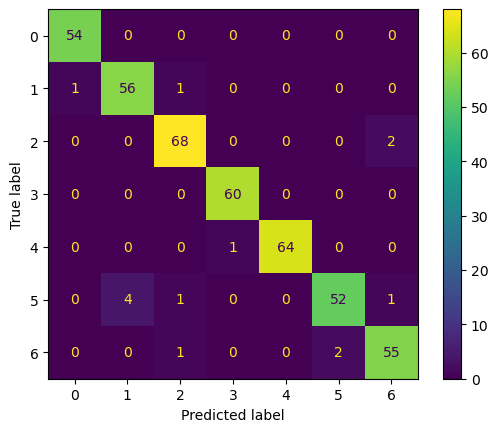

In [9]:
# Create SVC and Optuna confusion matrix
cm_svc_optuna = confusion_matrix(y_test_reshaped, y_pred_opt)

ConfusionMatrixDisplay(confusion_matrix=cm_svc_optuna).plot();